In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/emotion-dataset/validation.csv
/kaggle/input/emotion-dataset/training.csv
/kaggle/input/emotion-dataset/test.csv


In [2]:
import torch
import random
import os

def seed_everything(TORCH_SEED):
    random.seed(TORCH_SEED)
    os.environ['PYTHONHASHSEED'] = str(TORCH_SEED)
    np.random.seed(TORCH_SEED)
    torch.manual_seed(TORCH_SEED)
    torch.cuda.manual_seed_all(TORCH_SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# seed_everything(1126)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
import pandas as pd
import numpy as np
import warnings; warnings.filterwarnings('ignore')

validation_data = pd.read_csv('/kaggle/input/emotion-dataset/validation.csv')
train_data = pd.read_csv('/kaggle/input/emotion-dataset/training.csv')
test_data = pd.read_csv('/kaggle/input/emotion-dataset/test.csv')

print('Dataset information:')
print(f'Training data: {train_data.shape}')
print(f'Validation data: {validation_data.shape}')
print(f'Test data: {test_data.shape}')

Dataset information:
Training data: (16000, 2)
Validation data: (2000, 2)
Test data: (2000, 2)


In [5]:
labels = train_data['label'].unique()
labels_dict = {0:'sadness', 1:'joy', 2:'love', 3:'anger', 4:'fear', 5:'surprise'}
reverse_dict = {'sadness': 0, 'joy': 1, 'love': 2, 'anger': 3, 'fear': 4, 'surprise': 5}
emotions = list(labels_dict.values())

In [6]:
def select_data(df, emotion):
    tmp = list(df.label == emotion)
    result = df.loc[tmp, 'text']
    
    return result.iloc[0]

In [7]:
preamble = "You are an emotion recognition expert\nHere are some examples:\n\n"
unique_emotion = ', '.join(emotions)
interim_prompt = (f"Categorize the tweet into one of the following emotions: {unique_emotion}\n")
few_shot_prompt = ""

for e in emotions:
    label = reverse_dict.get(e)
    emotion_data = select_data(train_data, label)
    answer = f"\nEmotion: {e}\n\n"
    prompt = f"Example{label + 1}:\n" + interim_prompt + emotion_data + answer
    few_shot_prompt += prompt

In [8]:
final_prompt = preamble + few_shot_prompt +'\n' + interim_prompt

In [9]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
from string import Template

model_name='google/flan-t5-base'

tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name).to(device)

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [10]:
def predict(prompt):
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    outputs = model.generate(**inputs)
    result = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    
    return result[0]

In [11]:
answers = []
random_choice = []
redundant = 'emotion: '

for idx, value in test_data['text'].items():
    prompt = final_prompt + value
    answer = None
    count = 0
    
    while answer not in emotions:
        
        if count > 5:
            answer = random.choice(emotions)
            random_choice.append(idx)
            break
        
        answer = predict(prompt)
        
        if redundant in answer:
            answer = answer.replace(redundant, '')
    
        count += 1
    
    answers.append(answer)

In [12]:
y_preds = [reverse_dict.get(a) for a in answers]

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(y_model, y_true, labels):
    cm = confusion_matrix(y_true,y_model,normalize='true')
    fig, ax = plt.subplots(figsize=(7,7))
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
    disp.plot(ax=ax, colorbar=False)
    plt.title("Confusion matrix")
#     plt.axis('off')
    plt.grid(False)
    plt.show()

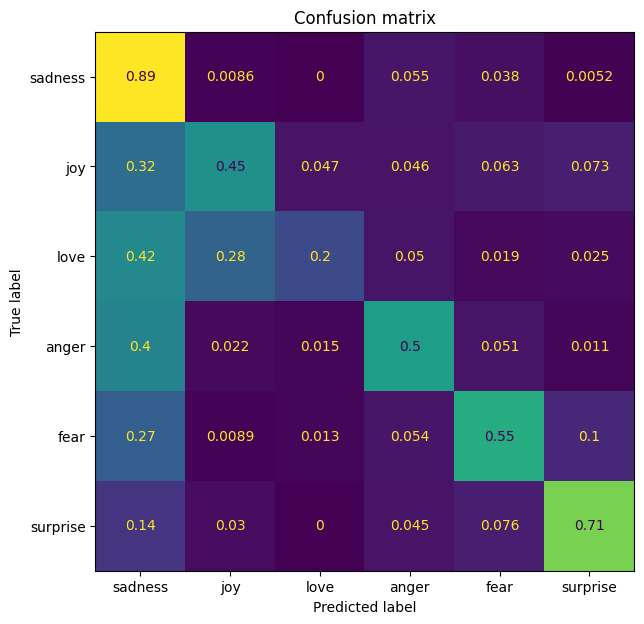

In [14]:
plot_confusion_matrix(y_preds, test_data['label'], labels_dict.values())

In [15]:
from sklearn.metrics import classification_report

print(classification_report(test_data['label'], y_preds, target_names = labels_dict.values()))

              precision    recall  f1-score   support

     sadness       0.53      0.89      0.66       581
         joy       0.84      0.45      0.58       695
        love       0.44      0.20      0.28       159
       anger       0.61      0.50      0.55       275
        fear       0.58      0.55      0.57       224
    surprise       0.36      0.71      0.48        66

    accuracy                           0.59      2000
   macro avg       0.56      0.55      0.52      2000
weighted avg       0.64      0.59      0.57      2000



In [16]:
print(len(random_choice))

142


In [17]:
print(random_choice)

[21, 29, 42, 67, 73, 101, 107, 116, 135, 146, 162, 170, 176, 186, 214, 248, 256, 276, 280, 300, 305, 319, 323, 344, 365, 396, 405, 406, 410, 413, 416, 418, 422, 425, 449, 473, 478, 488, 494, 554, 558, 563, 564, 567, 570, 578, 588, 608, 609, 613, 628, 638, 646, 653, 666, 695, 716, 733, 758, 762, 777, 796, 801, 805, 825, 925, 953, 969, 977, 987, 1038, 1039, 1042, 1043, 1059, 1074, 1139, 1146, 1182, 1188, 1190, 1199, 1215, 1235, 1239, 1254, 1271, 1286, 1302, 1345, 1348, 1358, 1364, 1366, 1367, 1391, 1403, 1408, 1428, 1441, 1450, 1468, 1481, 1486, 1487, 1501, 1512, 1514, 1524, 1531, 1532, 1591, 1594, 1597, 1601, 1607, 1620, 1635, 1638, 1662, 1688, 1725, 1733, 1736, 1767, 1770, 1774, 1777, 1794, 1850, 1858, 1875, 1876, 1893, 1898, 1904, 1916, 1931, 1936, 1971, 1977, 1996]


In [18]:
prompt = final_prompt + test_data['text'].iloc[21]
predict(prompt)

'appreciative'

In [19]:
print(test_data['text'].iloc[21])

i feel like ive gotten to know many of you through comments and emails and for that im appreciative and glad you are a part of this little space


In [20]:
prompt = final_prompt + test_data['text'].iloc[29]
predict(prompt)

'positive'

In [21]:
print(test_data['text'].iloc[29])

i highly recommend visiting on a wednesday if youre able because its less crowded so you get to ask the farmers more questions without feeling rude for holding up a line


In [29]:
prompt = final_prompt + test_data['text'].iloc[42]
predict(prompt)

'positive'

In [30]:
print(test_data['text'].iloc[42])

i feel reassured that i am dealing with my diet in the right way and that all is good


In [24]:
delusive_data = test_data['text'].iloc[random_choice]

In [25]:
delusive_answers = []

for idx, value in delusive_data.items():
    prompt = final_prompt + value
    answer = predict(prompt)
    if redundant in answer:
        nswer = answer.replace(redundant, '')
    
    delusive_answers.append(answer)

In [26]:
tmp = pd.Series(delusive_answers)
tmp.head()

0    appreciative
1        positive
2        positive
3          stress
4         empathy
dtype: object

In [27]:
tmp.value_counts()

positive               34
happy                  10
negative               10
stress                  7
hopeful                 5
excited                 5
anxiety                 4
overwhelmed             4
empathy                 3
gratitude               3
confusion               3
disgust                 2
determined              2
jealous                 2
curiosity               2
emotional: outgoing     2
shy                     2
emotional: brave        2
emotion: shy            1
bitter                  1
awe                     1
appreciative            1
emotion: masculine      1
energized               1
emotional: calm         1
thankful                1
fearless                1
emotion: calm           1
creative                1
emotion: important      1
normal                  1
discouraged             1
emotion: pride          1
emotion: need           1
emotion: smart          1
inspiration             1
emotion: empathy        1
social media            1
emotion: app

In [28]:
print(final_prompt + train_data['text'].iloc[0])

You are an emotion recognition expert
Here are some examples:

Example1:
Categorize the tweet into one of the following emotions: sadness, joy, love, anger, fear, surprise
i didnt feel humiliated
Emotion: sadness

Example2:
Categorize the tweet into one of the following emotions: sadness, joy, love, anger, fear, surprise
i have been with petronas for years i feel that petronas has performed well and made a huge profit
Emotion: joy

Example3:
Categorize the tweet into one of the following emotions: sadness, joy, love, anger, fear, surprise
i am ever feeling nostalgic about the fireplace i will know that it is still on the property
Emotion: love

Example4:
Categorize the tweet into one of the following emotions: sadness, joy, love, anger, fear, surprise
im grabbing a minute to post i feel greedy wrong
Emotion: anger

Example5:
Categorize the tweet into one of the following emotions: sadness, joy, love, anger, fear, surprise
i feel as confused about life as a teenager or as jaded as a yea